**Travail de veille avec technique récente**
-----------------
Ce notebook a objectif de tester une technique récente sur le traitement des images.<br>
Je vais tester une architecture Vision Transformer (GCViT) sur notre jeu de données. <br>


On procéde en 3 étapes :
- **Séparation des données d'entrainement, de validation et de test**
- **Entraînement du modèle GCVIT**
- **Mesure de l'accuracy du modèle sur le jeu de test**

# **Imports**

In [16]:
# Import des librairies basiques
import pandas as pd
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np

# Import des métriques 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Import des libraries de deep learning
import keras
from keras import ops
import tensorflow as tf
from gcvit_mod import GCViT
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
# Définit le nombre de coeurs utilisés à 10
os.environ['LOKY_MAX_CPU_COUNT'] = '10'

# Filtre les user warning de keras
warnings.filterwarnings('ignore', category=UserWarning)

# **Chargement des données nettoyées**

In [3]:
image_df = pd.read_pickle('flipkart_cleaned.pkl')
image_df.drop(columns=['product_name', 'description'], inplace=True)
print(image_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   image   1050 non-null   object  
 1   class   1050 non-null   category
dtypes: category(1), object(1)
memory usage: 9.4+ KB
None


Pour la suite du travail, je vais utiliser les données nettoyées et préparées dans le notebook précédent sur les images.<br>
J'assigne également le nombre de classes à prédire ainsi que la liste des classes dans 2 variables.

In [4]:
# Assigne le nombre de classes
n_classes = image_df['class'].nunique()

# Assigne la liste des classes
labels = list(image_df['class'].unique())

# **Séparation des données en train-test-split**

In [5]:
# train test split avec un jeu de test de 20%
X_train, X_test, y_train, y_test = train_test_split(image_df['image'], image_df['class'], test_size=0.2, random_state=314, stratify=image_df['class'])

# Regroupement des données en dataframe de train et de test
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

# **Evaluation du modèle de vision transfromer : GCViT (gcvitxxtiny)**

Le modèle GVCVIT pour Global Context Vision Transformer est un modèle de vision transformer qui a été entrainé sur un grand nombre de données et qui a donné des résultats très performants.<br>
Il découpe l'image en plusieurs patchs et les traite avec un modèle transformer.<br>
De cette manière, il capture les relations entre les différents patchs de l'image.<br>
Je vais évaluer ce modèle sur notre jeu de données pour voir s'il peut être utilisé pour notre classification.

Comme la data augmentation ne s'est pas révelé concluante sur EfficientNetB0, je vais tester le modèle GCViT sans data augmentation.<br>
L'entraînement est plus long car il s'agit de FineTuning sur ce type d'architecture.<br>
Il s'agit juste d'évaluer la faisabilité de classifier les images avec cette architecture prometteuse.<br>


La métrique d'évaluation que je vais utiliser est l'accuracy.<br>



In [6]:
# Paramètres de configuration du modèle
config = {
    "window_size": (7, 7, 14, 7),
    "embed_dim": 64,
    "depths": (2, 2, 6, 2),
    "num_heads": (2, 4, 8, 16),
    "mlp_ratio": 3.0,
    "path_drop": 0.2,
    "num_classes": n_classes,
}
# URL pour récupérer les poids du modèle gcvitxxtiny
ckpt_link = (
    "https://github.com/awsaf49/gcvit-tf/releases/download/v1.1.6/gcvitxxtiny.keras"
)

In [7]:
# Taille de l'input
IMAGE_SIZE = (224, 224)

# Hyper Params
BATCH_SIZE = 16
EPOCHS = 5

# Constantes pour la normalisation au vu des données d'entrainement imagenet
MEAN = 255 * np.array([0.485, 0.456, 0.406], dtype="float32")  # imagenet mean
STD = 255 * np.array([0.229, 0.224, 0.225], dtype="float32")  # imagenet std
AUTO = tf.data.AUTOTUNE

In [8]:
# Création de la fonction pour normaliser les images
def preprocess(image):
        # for training, do augmentation
        image = (image - MEAN) / STD  # normalization
        return image

In [9]:
# Définition de la fonction pour créer les jeux d'entrainement avec le preprocessing
def create_data_generator(data: pd.DataFrame, image_size: tuple = (224, 224), batch_size: int = 16, shuffle=True, subset='training') -> tf.keras.preprocessing.image.DirectoryIterator:
    # Création d'un Image Data Generator avec la fonction de preprocessing personnalisée
    datagen = ImageDataGenerator(
        preprocessing_function=lambda img: preprocess(img),
        validation_split=0.2 if subset != 'testing' else 0.0,
    )

    # Création du générateur de données à partir du dataframe de test
    data_generator = datagen.flow_from_dataframe(
        data,
        directory='images/',
        x_col='image',
        y_col='class',
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=shuffle,
        subset= None if subset == 'testing' else subset,
    )

    # Retourne le datagenerator de test
    return data_generator

In [10]:
# Création des datagenator pour le train, le test et la validation
train_datagen = create_data_generator(train, batch_size=BATCH_SIZE, subset='training', shuffle=True)
val_datagen = create_data_generator(train, batch_size=BATCH_SIZE, shuffle=False, subset='validation')
test_datagen = create_data_generator(test, batch_size=BATCH_SIZE, shuffle=False, subset='testing')

Found 672 validated image filenames belonging to 7 classes.
Found 168 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.


In [11]:
# Build the GCVIT MODEL
model = GCViT(**config)
inp = ops.array(np.random.uniform(size=(1, 224, 224, 3)))
out = model(inp)

# Chargement des poids pré-entrainés
ckpt_path = keras.utils.get_file(ckpt_link.split("/")[-1], ckpt_link)
model.load_weights(ckpt_path, skip_mismatch=True)

# Compilation du modèle
model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

# Définir le callback pour sauvegarder les poids du modèle
checkpoint = ModelCheckpoint(
    'best_model.weights.h5',
    save_weights_only=True,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1)

# Entraîne le modèle
history = model.fit(
    train_datagen,
    validation_data=val_datagen,
    epochs=5,
    callbacks=[checkpoint]
    )

Epoch 1/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3701 - loss: 1.6404

c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



Epoch 1: val_loss improved from inf to 1.10701, saving model to best_model.weights.h5
42/42 ━━━━━━━━━━━━━━━━━━━━ 366s 8s/step - accuracy: 0.3728 - loss: 1.6357 - val_accuracy: 0.6905 - val_loss: 1.1070
Epoch 2/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7019 - loss: 0.8511
Epoch 2: val_loss improved from 1.10701 to 1.04379, saving model to best_model.weights.h5
42/42 ━━━━━━━━━━━━━━━━━━━━ 330s 8s/step - accuracy: 0.7014 - loss: 0.8528 - val_accuracy: 0.6845 - val_loss: 1.0438
Epoch 3/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7693 - loss: 0.7111
Epoch 3: val_loss improved from 1.04379 to 0.72366, saving model to best_model.weights.h5
42/42 ━━━━━━━━━━━━━━━━━━━━ 343s 8s/step - accuracy: 0.7690 - loss: 0.7118 - val_accuracy: 0.7857 - val_loss: 0.7237
Epoch 4/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8809 - loss: 0.4015
Epoch 4: val_loss did not improve from 0.72366
42/42 ━━━━━━━━━━━━━━━━━━━━ 307s 7s/step - accuracy: 0.8804 - loss: 0.4030 - val_accuracy: 0.

In [12]:
def plot_learning_curves(history: tf.keras.callbacks.History, scenario: str) -> None:
    # Crée une figure pour afficher les courbes d'apprentissage sur l'accuracy et la perte
    fig, ax = plt.subplots(1, 2, figsize=(14, 6), tight_layout=True)
    fig.suptitle(f"Evaluation scénario {scenario}", fontweight='bold', fontsize=16)
    # Affiche la courbe de l'accuracy
    ax[0].plot(history.history['accuracy'], label='train_accuracy')
    ax[0].plot(history.history['val_accuracy'], label='validation_accuracy')
    ax[0].set_title("Courbes d'apprentissage de l'accuracy", fontweight='bold')
    ax[0].set_ylabel('Accuracy')
    # Affiche la courbe de la perte
    ax[1].plot(history.history['loss'], label='train_loss')
    ax[1].plot(history.history['val_loss'], label='validation_loss')
    ax[1].set_title("Courbes d'apprentissage de la perte", fontweight='bold')
    ax[1].set_ylabel('Loss')
    for i in range(2):
        ax[i].set_xticks(range(0, n_epochs, 2))
        ax[i].set_xlabel('Epochs')
        ax[i].grid(axis='both', linestyle='--')
        ax[i].legend()
    plt.show()

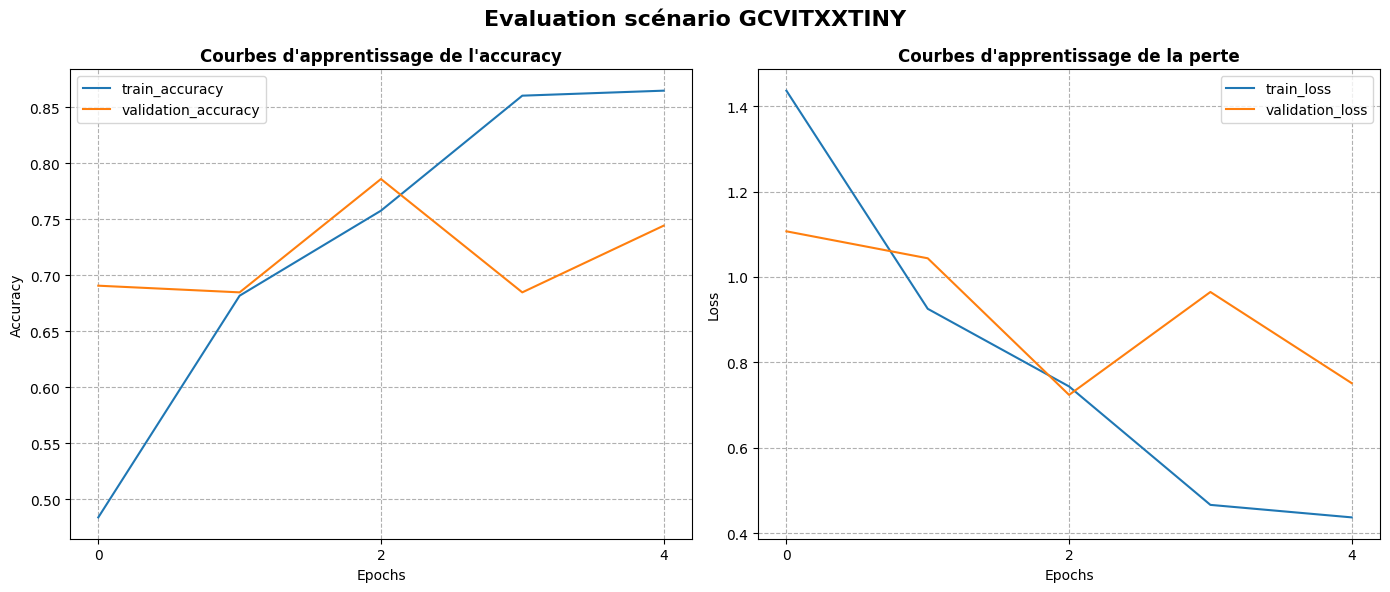

In [13]:
# Récupère le nombre d'EPOCHS utilisés
n_epochs = len(history.history['loss'])

# Affiche les courbes d'apprentissage
plot_learning_curves(history, "GCVITXXTINY")

Le modèle apprends sur le jeu d'entraînement mais n'arrive pas à minimiser la loss sur le jeu de validation.<br>
Regardons la matrice de confusion pour voir les classes mal prédites.

In [14]:
# Définit le nom du modèle à charger
model_name = 'best_model.weights.h5'

# Charger les poids du modèle sauvegardés
model.load_weights(model_name)

# Évaluer le modèle avec les poids chargés
score = model.evaluate(test_datagen)
print(f"Test loss: {score[0]}")
print(f"Test accuracy: {score[1]}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 110s 8s/step - accuracy: 0.7137 - loss: 0.8573
Test loss: 0.8060100674629211
Test accuracy: 0.723809540271759


14/14 ━━━━━━━━━━━━━━━━━━━━ 74s 5s/step


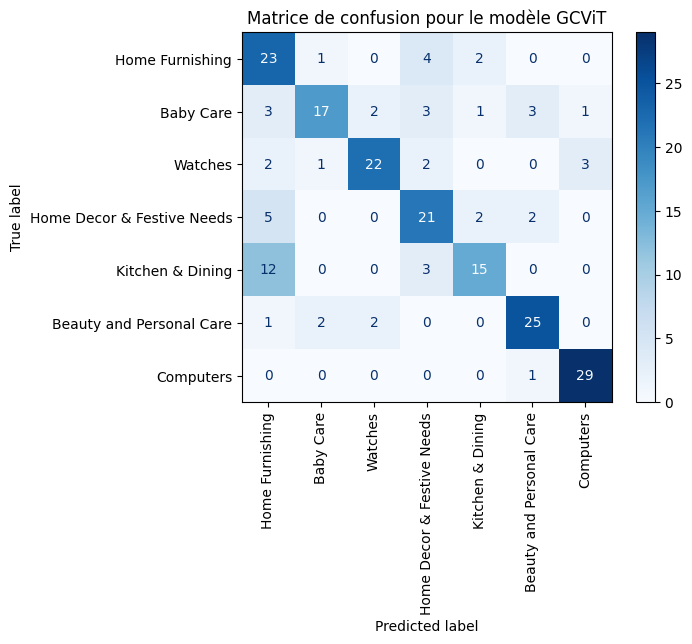

In [17]:
# Récupère les probabilités prédites par le modèle pour chaque classe
y_preds = model.predict(test_datagen)

# Calcule la matrice de confusion
cm = confusion_matrix(test_datagen.classes, y_preds.argmax(axis=1))

# Crée l'objet de display de la matrice de confusion
cm_display = ConfusionMatrixDisplay(cm, display_labels=labels)

# Affiche la matrice de confusion
cm_display.plot(cmap='Blues', xticks_rotation='vertical')
plt.title("Matrice de confusion pour le modèle GCViT")
plt.show()
